###  02. Neural Network Classification

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options) 


#### Make classification data and prepare it

In [2]:
from sklearn.datasets import make_circles

In [3]:
# Make 1000 Samples
from sklearn.datasets import make_circles
n_samples = 1000

# Create Circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [4]:
len(X), len(y)

(1000, 1000)

In [5]:
print(f'First 5 Samples of X:\n{X[:5]}\n')
print(f'First 5 Samples of y:\n{y[:5]}\n')

First 5 Samples of X:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 Samples of y:
[1 1 1 1 0]



y is binary classification --> 0 or 1

In [6]:
# Make DataFrame of circle data
from turtle import circle
import pandas as pd


circles = pd.DataFrame({"X1" : X[:,0], 
                        "X2" : X[:,1], 
                        "label" : y})

circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


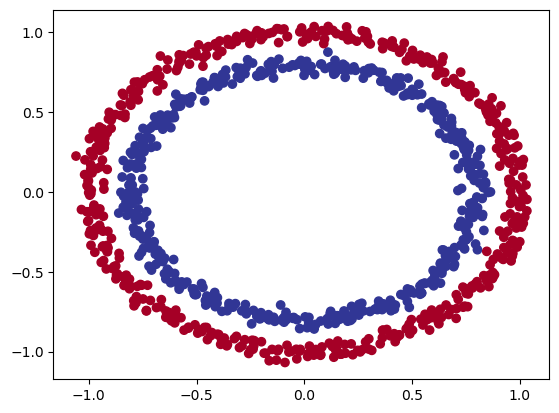

In [7]:
# Visualize the data 
import matplotlib.pyplot as plt

plt.scatter(x=X[:,0], 
            y=X[:,1], 
            c=y, 
            cmap=plt.cm.RdYlBu)


Note: The data we're working with is often called "toy data" or "synthetic data" because it's data we make up to try and mimic real-world data. It is small enough to experiment with but still sizeable enough to practice the fundamentals

#### Check input and output shapes

In [8]:
import torch
X.shape, y.shape

# Turn data into tensors

X = torch.from_numpy(X).type(torch.float)

y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]



(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [9]:
# Split the data into train and test sets (use a random split)

from sklearn.model_selection import train_test_split


def split_data(X, y):
    return train_test_split(X, 
                            y, 
                            test_size=0.2, # 20% of data goes to test set 
                            random_state=42)

X_train, X_test, y_train, y_test = split_data(X, y)


In [10]:
# Check the length of the train and test data
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

### Build a model

Build a model to classify the dots / data

To do:
1. Set up device agnostic code so our code will run on GPU if available
2. Construct a model (by subclassing nn.Module)
3. Define a loss function and optimizer
4. Create a training and testing loop


In [11]:
# Set up device agnostic code
import torch 
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

##### Construct a model class

Now that device agnostic code is set up, create a model that

1. Subclasses `nn.Module` (Pretty much every model subclasses `nn.Module`)
2. Create 2 `nn.Linear()` layers capable of handling shapes of data(Am I using the Kernel Trick?)
3. Define a `forward()` method that outline the forward pass (or forward computation)
4. Instantiate an instance of our model class and send it to the target `device`


In [12]:
# Construct a model that subclasses the nn.Module PyTorch class

import torch.nn as nn

class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        # Create 2 linear layers using nn.Linear which can handle the data
        self.layer_1 = nn.Linear(in_features=2, out_features=8) # how many neurons
        self.layer_2 = nn.Linear(in_features=8, out_features=1) # how many neurons (in_features must match previous out_features)
    
    # Define the forward pass of the model
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x --> layer 1 --> layer 2 --> output
    
# Instantiate an instance of our model class and send it to the target device
model_1 = CircleModelV1().to(device)
model_1 


CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=1, bias=True)
)

In [13]:
# Check the target device
device

# Check to see where the model's parameters are
next(model_1.parameters()).device

device(type='cuda', index=0)

In [14]:
# Replicating the model using nn.Sequential()

import torch.nn as nn
model_1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=8),
    nn.Linear(in_features=8, out_features=1).to(device)
).to(device)

model_1

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Linear(in_features=8, out_features=1, bias=True)
)

In [15]:
# Make some predictions with the model

model_1.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.3104,  0.0937],
                      [ 0.6877,  0.0050],
                      [-0.0926, -0.3264],
                      [ 0.6493,  0.0032],
                      [-0.0387, -0.1933],
                      [ 0.5471,  0.1943],
                      [ 0.1479, -0.5544],
                      [ 0.6181, -0.4837]], device='cuda:0')),
             ('0.bias',
              tensor([-0.4427,  0.2223, -0.5929, -0.2353, -0.6669,  0.6847, -0.3727, -0.1614],
                     device='cuda:0')),
             ('1.weight',
              tensor([[-0.0205,  0.2686,  0.1180,  0.0478,  0.0041, -0.2420, -0.3519, -0.3072]],
                     device='cuda:0')),
             ('1.bias', tensor([0.3291], device='cuda:0'))])

In [16]:
# Make untrained predictions
with torch.inference_mode():
    untrained_preds = model_1(X_test.to(device))
print(f"length of untrained_preds: {len(untrained_preds)} Shape: {untrained_preds.shape}")
print(f'Length of test sample: {len(X_test)}, Shape: {X_test.shape}')
print(f'\nFirst 10 Predictions:\n{untrained_preds[:10]}')
print(f'\nFirst 10 Labels:\n{y_test[:10]}')

length of untrained_preds: 200 Shape: torch.Size([200, 1])
Length of test sample: 200, Shape: torch.Size([200, 2])

First 10 Predictions:
tensor([[0.5704],
        [0.5729],
        [0.3718],
        [0.6275],
        [0.0670],
        [0.0709],
        [0.3196],
        [0.2012],
        [0.3850],
        [0.5697]], device='cuda:0')

First 10 Labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### Pick a loss function and optimizer

Use the `torch.nn.functional.binary_cross_entropy` loss function
(input, target, weight=None, size_average=None, reduce=None, reduction='mean')



In [17]:
import torch.nn.functional as F
import torch


loss_fn = F.binary_cross_entropy_with_logits
# We use binary cross entropy with logits because our model is giving us logits (raw predictions) and not probabilities,
# This allows up to have some form of numerical stability when calculating the loss

optimizer = torch.optim.Adam(model_1.parameters(), 
                            lr=0.001)

# Calculating accuracy - out of 100 examples, what percentage did we get correct?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

### Training Loop

1. Forward propagation
2. Calculate the loss
3. Optimzer Zero Grad
4. Backpropagation
5. Optimizer step (gradient descent)


### From: Raw Logits --> Predictions Probabilities --> Class Labels

Our model outputs are going to be raw **logits**.

We convert these **logits** into prediction probabilities by passing them to some kind of activation function (sigmoid for binary classification and softmax for multiclass classification problem)

Then we can convert our model's prediction proabilities by either rounding them or taking the argmax()

In [18]:
with torch.inference_mode():
    y_logits = model_1(X_test.to(device))[:5]
y_logits

tensor([[0.5704],
        [0.5729],
        [0.3718],
        [0.6275],
        [0.0670]], device='cuda:0')

In [19]:
# Use the sigmoid activation function to transform logits to probabilities
y_pred_probs = F.sigmoid(y_logits)
y_pred_probs

tensor([[0.6389],
        [0.6394],
        [0.5919],
        [0.6519],
        [0.5167]], device='cuda:0')

For our prediction probability values, we need to perform a range style rounding on them:
* `y_pre_probs` >= 0.5, `y=1` (Class 1)
* `y_pre_probs` < 0.5, `y=0` (Class 0)

In [20]:
y_preds = torch.round(y_pred_probs)

with torch.inference_mode():
    y_pred_labels = torch.round(torch.sigmoid(model_1(
                                        X_test.to(device))[:5]))
    
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze(),

tensor([True, True, True, True, True], device='cuda:0')


(tensor([1., 1., 1., 1., 1.], device='cuda:0'),)

### Building a training loop


In [21]:
# Import dependencies

from re import M
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Set random seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set device
# Setting the training and testing data as device agnostic
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Create a testing loop to train the model
# 1. For an epoch in a range
# 2. Call model.train() to set the model to training mode
# 3. Do the forward pass of the model
# 4. Calculate the loss
# 5. Call model.zero_grad() to clear the gradients
# 6. Optimizer.step() to update the model parameters

MODEL = model_1
epochs = 100
LR = 0.001
OPTIMIZER = optim.Adam(MODEL.parameters(), lr=LR)

# Reshape the tensors to match [800, 1]


for epoch in range (epochs):
    ##### TRAINING #####
    MODEL.train()
    
    #1. Do the forward pass
    y_logits = MODEL(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))
    
    #2. Calculate the loss / accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, 
                    y_pred=y_preds)
    
    # Optimizer zero grad
    OPTIMIZER.zero_grad()
    
    # Backpropagation
    loss.backward()
    
    # Update the parameters
    OPTIMIZER.step()
    
    ##### Testing #####
    MODEL.eval()
    with torch.inference_mode():
        
        # Forward Pass
        y_test_logits = MODEL(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(y_test_logits))
        
        # Calculate the loss / accuracy
        test_loss = loss_fn(y_test_logits, 
                            y_test)
        test_acc = accuracy_fn(y_test,
                            test_preds)
        
    # Print the metrics
    if epoch % 10 == 0:
        print(f"""
        Epoch: {epoch}
        Train loss: {loss:.4f} Train Acc: {acc:.2f}%
        Test loss: {test_loss:.4f} Test Acc: {test_acc:.2f}%
        """)
    


        Epoch: 0
        Train loss: 0.7102 Train Acc: 50.00%
        Test loss: 0.7153 Test Acc: 50.00%
        

        Epoch: 10
        Train loss: 0.7052 Train Acc: 52.38%
        Test loss: 0.7094 Test Acc: 51.00%
        

        Epoch: 20
        Train loss: 0.7012 Train Acc: 57.63%
        Test loss: 0.7047 Test Acc: 55.50%
        

        Epoch: 30
        Train loss: 0.6981 Train Acc: 59.75%
        Test loss: 0.7012 Test Acc: 55.50%
        

        Epoch: 40
        Train loss: 0.6959 Train Acc: 56.62%
        Test loss: 0.6987 Test Acc: 55.00%
        

        Epoch: 50
        Train loss: 0.6945 Train Acc: 54.25%
        Test loss: 0.6970 Test Acc: 53.00%
        



        Epoch: 60
        Train loss: 0.6937 Train Acc: 54.00%
        Test loss: 0.6960 Test Acc: 51.00%
        

        Epoch: 70
        Train loss: 0.6933 Train Acc: 52.50%
        Test loss: 0.6954 Test Acc: 50.00%
        

        Epoch: 80
        Train loss: 0.6931 Train Acc: 51.75%
        Test loss: 0.6951 Test Acc: 49.00%
        

        Epoch: 90
        Train loss: 0.6930 Train Acc: 51.25%
        Test loss: 0.6949 Test Acc: 47.00%
        


## 4. Make predictions and evaluate the model ##

From the metrics it looks like the model is not learning anuything

Let's make the data visual

To do so, use `plot_decision_boundary()`

In [22]:
import requests
from pathlib import Path

# Download helper functions from PyTorch repo (if not already downloaded)
if Path('helper_functions.py').is_file() != True:
    url = 'https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py'
    r = requests.get(url)
    with open('helper_functions.py', 'w') as f:
        f.write(r.text)
        
from helper_functions import plot_predictions, plot_decision_boundary

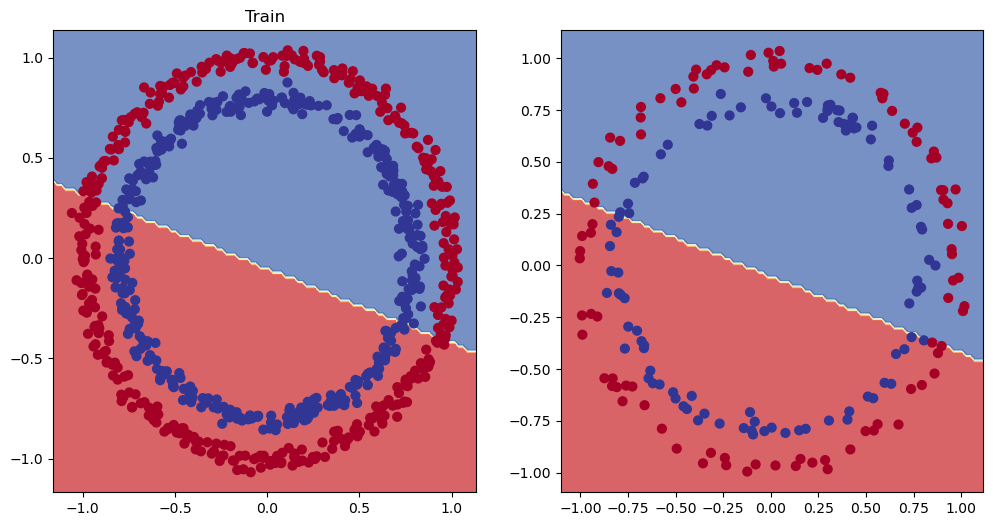

In [23]:
# Plot decision boundary of the model
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model=model_1,
                        X=X_train,
                        y=y_train)

plt.subplot(1, 2, 2)
plot_decision_boundary(model=model_1, X=X_test, y=y_test)

### Improving the model (from a model perspective)

* Add more layers - gives the models more chances to learn about specific patterns in the data
* Add more neurons in the hidden layers 
* Add more epochs
* Changing the activation functions
* Change the learning rate

These options are all from the model's perspective because these are variables that can be changed within the model architecture

Improve the model by:
* Adding more hidden neurons 8 -> 512
* Adding more layers 2-> 5
* Increase the number of epochs 100-> 1000

**Typically** only change one variable at a time

In [24]:
# import dependencies
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


# Set random seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train, y_train = X_train.to(device), y_train.to(device)

# Create a new model with different hyperparameters
class CircleModelV2(nn.Module):
    
    def __init__(self):
        super().__init__()
        # Create a model
        self.layer_1 = nn.Linear(2, 16)
        self.layer_2 = nn.ReLU()
        self.layer_3 = nn.Linear(16, 8)
        self.layer_4 = nn.ReLU()
        self.layer_5 = nn.Linear(8, 1)
    
    def forward(self, x):
        # Trying with 3 layers and No ReLU activation
        #return self.layer_5(self.layer_3(self.layer_1(x)))
        return self.layer_5(self.layer_4(self.layer_3(self.layer_2(self.layer_1(x)))))
    
model_2 = CircleModelV2().to(device)
model_2

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=16, bias=True)
  (layer_2): ReLU()
  (layer_3): Linear(in_features=16, out_features=8, bias=True)
  (layer_4): ReLU()
  (layer_5): Linear(in_features=8, out_features=1, bias=True)
)

In [25]:
# Create a loss function
import torch
loss_fn = F.binary_cross_entropy_with_logits

# Create an optimizer
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

# Put all data and model on same processing device

device = "cuda" if torch.cuda.is_available() else "cpu"
model_2.to(device)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Write a training loop and evaluation loop for model_2
epochs = 1000
LR = 0.001
optimizer = optim.Adam(model_2.parameters(), lr=LR)

for epoch in range(epochs):
    ### TRAINING ###
    model_2.train()
    
    # Forward pass
    y_logits = model_2(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))
    
    
    # Calculate loss / accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, 
                    y_pred=y_preds)
    
    # Optimizer zero grad
    optimizer.zero_grad()
    
    # Backpropagation
    loss.backward()
    
    # Update the parameters
    optimizer.step()
    
    ############ EVALUATION ###############
    model_2.eval()
    # Forward pass
    with torch.inference_mode():
        
        # Forward pass
        test_logits = model_2(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        
        # Calculate loss / accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                                y_pred=test_preds)

    # Print the results
    if epoch % 100 == 0:
        print(f"""
        Epoch: {epoch}
        Train loss: {loss:.4f}
        Train accuracy: {acc:.4f}
        Test loss: {test_loss:.4f}
        Test accuracy: {test_acc:.4f}
        Test accuracy: {test_acc:.4f}
        """)


        Epoch: 0
        Train loss: 0.7017
        Train accuracy: 50.0000
        Test loss: 0.7015
        Test accuracy: 50.0000
        Test accuracy: 50.0000
        

        Epoch: 100
        Train loss: 0.6855
        Train accuracy: 58.6250
        Test loss: 0.6857
        Test accuracy: 57.0000
        Test accuracy: 57.0000
        

        Epoch: 200
        Train loss: 0.6596
        Train accuracy: 67.1250
        Test loss: 0.6674
        Test accuracy: 62.5000
        Test accuracy: 62.5000
        

        Epoch: 300
        Train loss: 0.5770
        Train accuracy: 88.1250
        Test loss: 0.6013
        Test accuracy: 83.5000
        Test accuracy: 83.5000
        

        Epoch: 400
        Train loss: 0.4339
        Train accuracy: 97.5000
        Test loss: 0.4763
        Test accuracy: 92.5000
        Test accuracy: 92.5000
        

        Epoch: 500
        Train loss: 0.2810
        Train accuracy: 99.8750
        Test loss: 0.3237
        Test accu

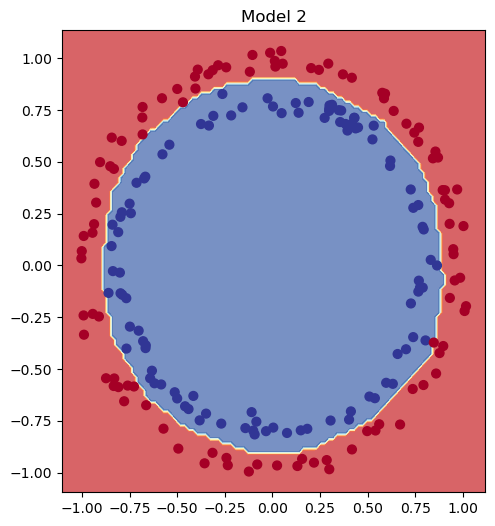

In [26]:
# Plot the decision boundary of model_2

import matplotlib.pyplot as plt

# Use helper function to plot decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Model 2')
plot_decision_boundary(model=model_2,
                        X=X_test, 
                        y=y_test)



Using linear and non-linear activation functions allows us to combine the power of both. 

### Recreating non-linear data with a neural network

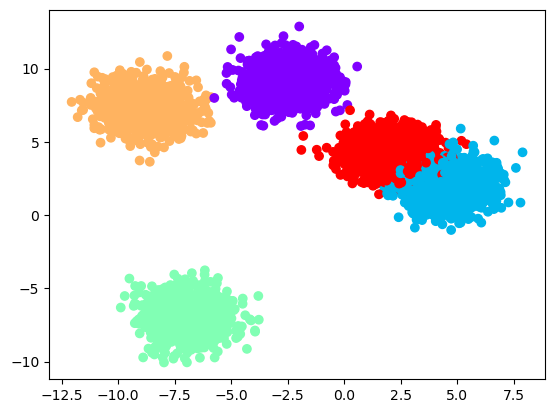

In [196]:
# Make and plot the data

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

n_samples = 5000

X_blob, y_blob = make_blobs(n_samples=n_samples,
                    centers=5,
                    random_state=42)

plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap='rainbow')

In [205]:
# Split into train and test sets

import torch
from sklearn.model_selection import train_test_split

#Convert the data to PyTorch tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# Split the data into training and testing
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, 
                                                    y_blob, 
                                                    test_size=0.2, 
                                                    random_state=42)


TypeError: expected np.ndarray (got Tensor)

In [198]:
# Put the data on target device with device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

In [199]:
# Build a multi-class classification model

class BlobModelV1(nn.Module):
    def __init__(self, input_features, output_features, hidden_features=8):
        """
        Initializes multi-class classification model.
        
        Args:
            input_features (int): number of input features
            output_features (int): number of output features
            hidden_layers (int): number of hidden layers
        
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(input_features, hidden_features),
            #nn.ReLU(),
            nn.Linear(hidden_features, hidden_features),
            #nn.ReLU(),
            nn.Linear(hidden_features, hidden_features),
            #nn.ReLU(),
            nn.Linear(hidden_features, output_features))
    
    def forward(self, x):
        return self.linear_layer_stack(x)

In [200]:
# Instantiate the model and send it to the target device
blob_model = BlobModelV1(2,5,16)
blob_model.to(device)

BlobModelV1(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=5, bias=True)
  )
)

In [201]:
import torch.optim as optim

loss_fn = F.cross_entropy
optimizer = optim.Adam(blob_model.parameters(), lr=1e-3)

In [203]:
# Create a training a testing loop for blob_model
epochs = 1000
LR = 0.001

# Put the data on target device
# Convert numpy arrays to PyTorch tensors
X_blob_train = torch.from_numpy(X_blob_train).float().to(device)
y_blob_train = torch.from_numpy(y_blob_train).long().to(device)
X_blob_test = torch.from_numpy(X_blob_test).float().to(device)
y_blob_test = torch.from_numpy(y_blob_test).long().to(device)

for epoch in range(epochs):
    
    ################### TRAINING #####################
    blob_model.train()
    
    # Forward pass
    y_logits = blob_model(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    
    # Calculate loss / accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                        y_pred=y_pred)
    
    # Optimizer zero grad
    optimizer.zero_grad()
    
    # Backpropagation
    loss.backward()
    
    # Optimizer step
    optimizer.step()
    
    ################### EVALUATION #####################
    blob_model.eval()
    
    # Forward pass
    with torch.inference_mode():
        
        # Forward pass
        test_logits = blob_model(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
        
        # Calculate loss / accuracy
        test_loss = loss_fn(test_logits, y_blob_test).type(torch.LongTensor)
        test_acc = accuracy_fn(y_true=y_blob_test,
                                y_pred=test_preds)
        
    # Print the results
    if epoch % 100 == 0:
        print(f"""
        Epoch: {epoch}
        Train loss: {loss:.4f}
        Train accuracy: {acc:.4f}
        Test loss: {test_loss:.4f}
        Test accuracy: {test_acc:.4f}
        Test accuracy: {test_acc:.4f}
        """)

TypeError: expected np.ndarray (got Tensor)

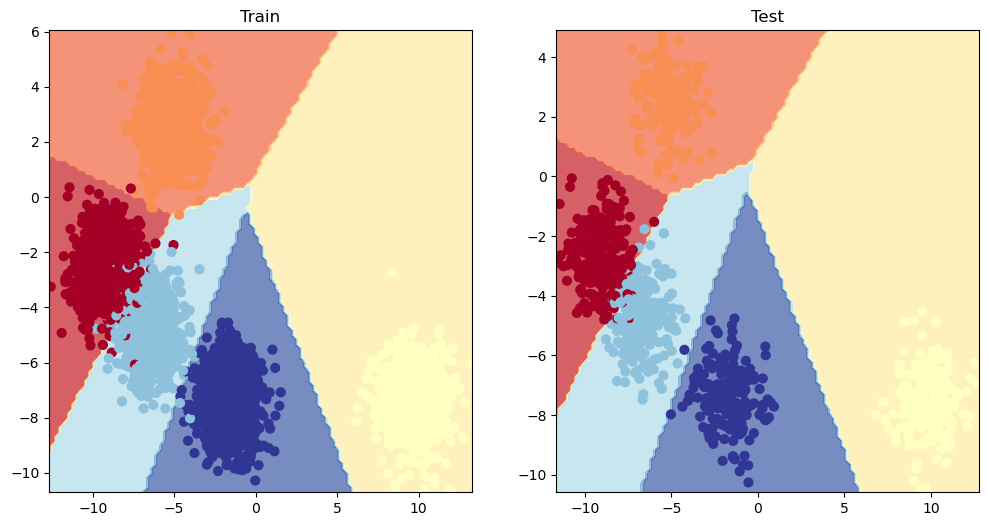

In [ ]:
# Use the helper fuctions to plot the decision boundary of blob_model

import matplotlib.pyplot as plt

# Use helper function to plot decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(blob_model, X_blob_train, y_blob_train)

plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(blob_model, X_blob_test, y_blob_test)


In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000



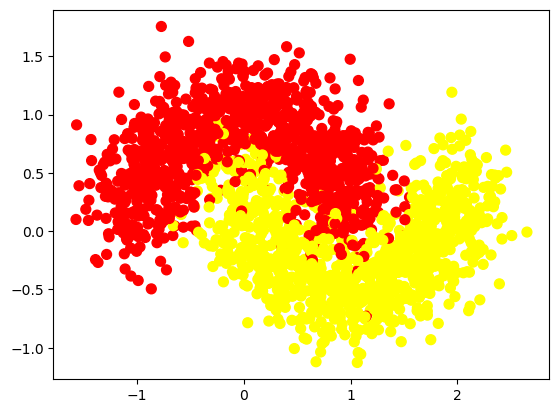

In [ ]:
import torch
from sklearn.datasets import make_moons

n_samples = 2000

X, y = make_moons(n_samples=n_samples,
                    noise=0.25,
                    random_state=42)

# Visualize the data

import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

In [ ]:
# Transform the data into tensors and split into train and test sets

import torch
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)

# Split the data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [ ]:
# Define a model

MoonModelV1 = nn.Sequential(
    nn.Linear(2, 32),
    nn.LeakyReLU(),
    nn.Linear(32, 64),
    nn.LeakyReLU(),
    nn.Linear(64, 128),
    nn.LeakyReLU(),
    nn.Linear(128, 16),
    nn.LeakyReLU(),
    nn.Linear(16, 1)
)



In [ ]:
import torch.optim as optim
import torch.nn.functional as F
import torch

moon_loss_fn = F.binary_cross_entropy_with_logits
moon_optimizer = optim.Adam(MoonModelV1.parameters(), lr=1e-3)

# Create a training and testing loop for MoonModelV1

epochs = 1000

for epoch in range(epoch):
    ############# TRAINING ##############
    MoonModelV1.train()
    
    # Forward pass
    y_logits = MoonModelV1(X_train).squeeze()
    y_pred = torch.round(torch.softmax(y_logits))
    
    # Calculate loss / accuracy
    loss = moon_loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, 
                    y_pred=y_pred)
    
    # Optimizer zero grad
    moon_optimizer.zero_grad()
    
    # Backpropagation
    loss.backward()
    
    # Optimizer step
    moon_optimizer.step()
    
    ############# EVALUATION ##############
    MoonModelV1.eval()
    with torch.inference_mode():
        
    
    # Forward pass
    test_y_logits = MoonModelV1(X_test).squeeze()
    test_y_pred = torch.round(torch.softmax(test_y_logits))
    
    # Calculate loss
    test_loss = moon_loss_fn(test_y_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                            y_pred=test_y_pred)
    
    # Print the results
    print(f"""
            Epoch: {epoch}
            Train loss: {loss:.4f}, Train accuracy: {acc:.4f}
            Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}
        """)

IndentationError: expected an indented block after 'with' statement on line 36 (693771740.py, line 40)

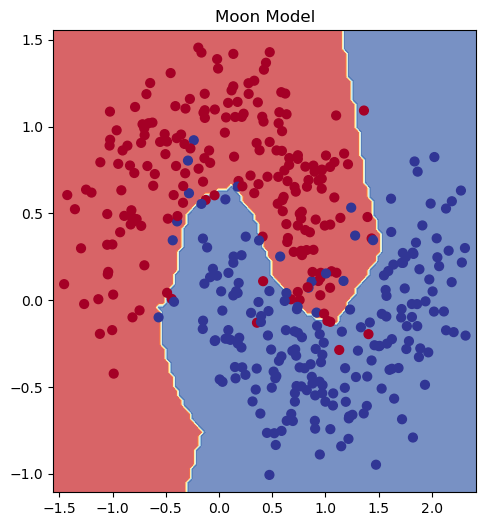

In [ ]:
import matplotlib.pyplot as plt

# Use helper function to plot decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Moon Model')
plot_decision_boundary(model=MoonModelV1,
                        X=X_test, 
                        y=y_test)